In [1]:
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn
import BasicFunctions as bf

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import functional as F 

In [2]:
os.chdir('C:\\Users\\Yaroslav\\YandexDisk\\Pr\\Py\\ML\\DataCreation\\output')
X = np.load('X_base_line_ones30.npz')
y = np.load('Y_base_line30.npz')
name = 'city'

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X[name], y[name])
batch_size = 100

train_loader = DataLoader(
    dataset=list(zip(X_train, y_train)), 
    batch_size=batch_size, 
    shuffle=True)

test_loader = DataLoader(
    dataset=list(zip(X_test, y_test)), 
    batch_size=batch_size, 
    shuffle=True)

In [21]:
class basicNet(nn.Module):
    def __init__(self):
        super(basicNet, self).__init__()
    
        #self.net = nn.Sequential()
        self.lin1 = nn.Linear(100, 200)
        self.lin2 = nn.Linear(200, 300)
        self.lin3 = nn.Linear(300, 400)
        self.lin4 = nn.Linear(400, 500)
        self.lin5 = nn.Linear(500, 600)
        self.lin6 = nn.Linear(600, 700)
        self.lin7 = nn.Linear(700, 800)
        self.lin8 = nn.Linear(800, 900)
        self.lin9 = nn.Linear(900, 3600)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d((2, 2), stride=(2, 2))

    def forward(self, x):
        x1 = self.relu(self.lin1(x))
        x1 = self.relu(self.lin2(x1))
        x1 = self.relu(self.lin3(x1)) + F.interpolate(x.reshape(x.shape[0], 1, 10, 10), 
                                                      scale_factor=2, mode='bilinear',
                                                      align_corners=False).reshape(x.shape[0], 400)
        x1 = self.relu(self.lin4(x1))
        x1 = self.relu(self.lin5(x1))
        x1 = self.relu(self.lin6(x1))
        x1 = self.relu(self.lin7(x1))
        x1 = self.relu(self.lin8(x1))
        x1 = self.relu(self.lin9(x1))
        x1 = self.avgpool(x1.reshape(x1.shape[0], 1, 60, 60)).reshape(x1.shape[0], 900)
        
        return x1

In [13]:
class littleNet(nn.Module):
    def __init__(self):
        super(littleNet, self).__init__()
    
        #self.net = nn.Sequential()
        self.lin1 = nn.Linear(100, 400)
        self.lin2 = nn.Linear(400, 3600)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d((2, 2), stride=(2, 2))

    def forward(self, x):
        x1 = self.relu(self.lin1(x)) + F.interpolate(x.reshape(x.shape[0], 1, 10, 10), 
                                                      scale_factor=2, mode='bilinear',
                                                      align_corners=False).reshape(x.shape[0], 400)
        x1 = self.relu(self.lin2(x1))
        x1 = self.avgpool(x1.reshape(x1.shape[0], 1, 60, 60)).reshape(x1.shape[0], 900)
        
        return x1

In [22]:
cuda_net = basicNet()
cuda_net = cuda_net.cuda()

learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cuda_net.parameters(), lr=learning_rate)

In [28]:
train_cuda_MSE, test_cuda_MSE = bf.net_cuda_training(cuda_net, train_loader, test_loader,
                                                     criterion, learning_rate, 600)

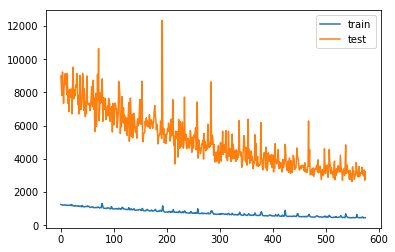

In [29]:
plt.plot(train_cuda_MSE[25:], label='train')
plt.plot(test_cuda_MSE[25:], label= 'test')
plt.legend()

In [30]:
pic = np.resize(cuda_net(torch.tensor(X_test[0]).reshape(1,100).type(torch.cuda.FloatTensor)).data, (30, 30))
original_pic = np.resize(y_test[0], (30, 30))

In [31]:
pic_bilinear = F.interpolate(torch.tensor(np.resize(X_test[0], (1, 1, 10, 10)), 
                                          dtype=torch.float32), scale_factor=3,
                             mode='bilinear').reshape(30, 30)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


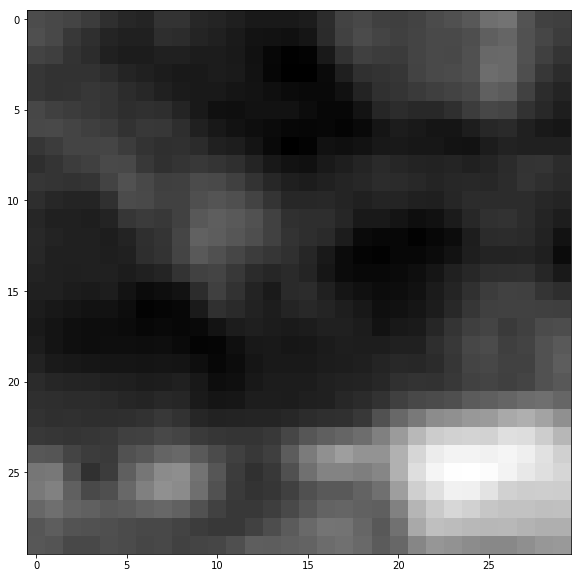

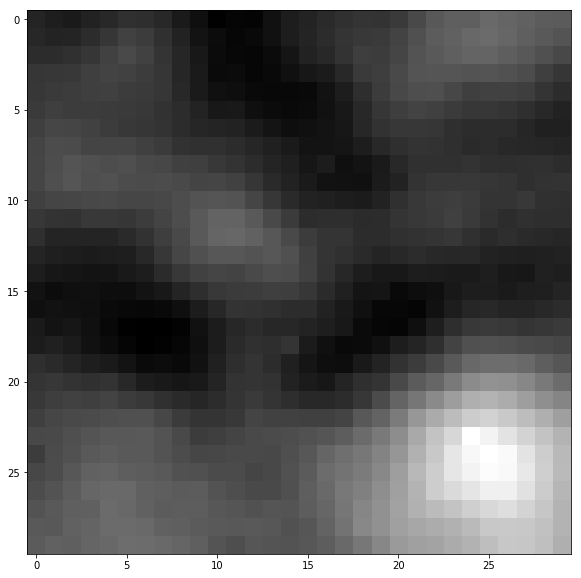

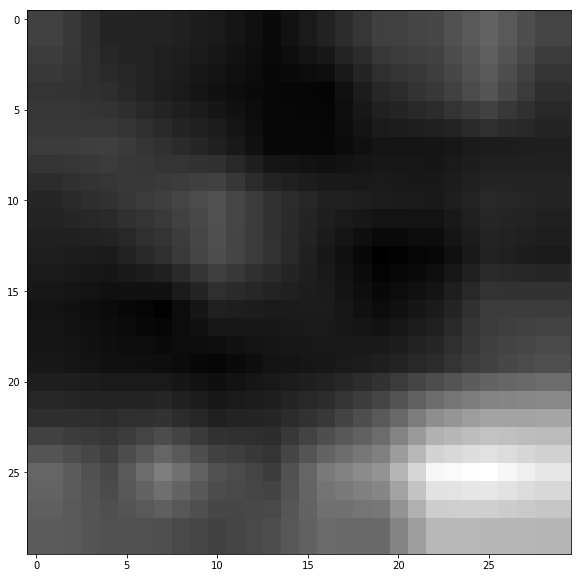

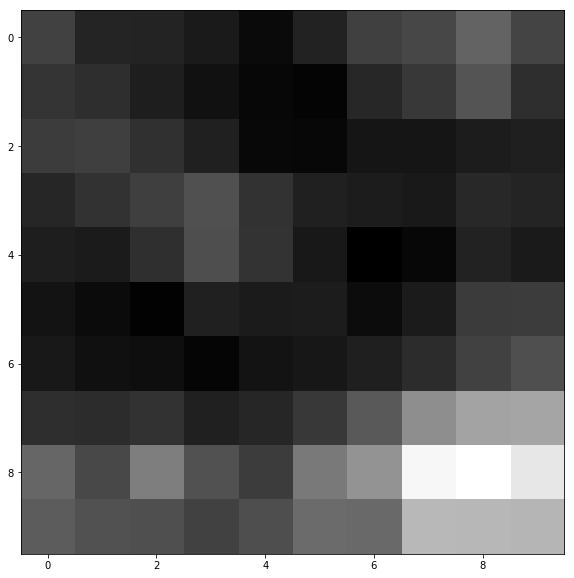

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(original_pic, cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(pic, cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(pic_bilinear, cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(np.resize(X_test[0], (10, 10)), cmap='gray')
plt.show()

In [134]:
(y[name].shape[1] * y[name].shape[0]) ** 0.5

1560.0

In [137]:
def whole_pic(X):
    L = int((X.shape[0] * X.shape[1]) ** 0.5)
    picture = np.zeros((L, L))
    d = int((X.shape[1]) ** 0.5)
    k = 0
    for i in range(0, L, d):
        for j in range(0, L, d):
            picture[i: i + d, j: j + d] = np.reshape(X[k], (d, d))
            k += 1
    return picture

In [138]:
answer = cuda_net(torch.tensor(X[name]).type(torch.cuda.FloatTensor)).type(torch.FloatTensor).data
rest_picture = whole_pic(answer.numpy())

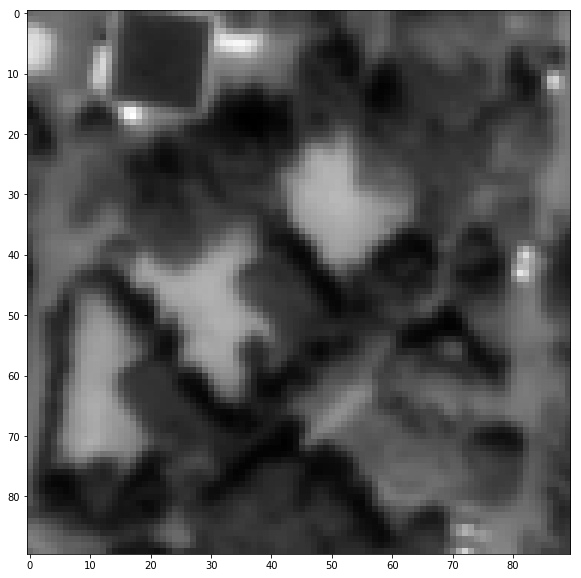

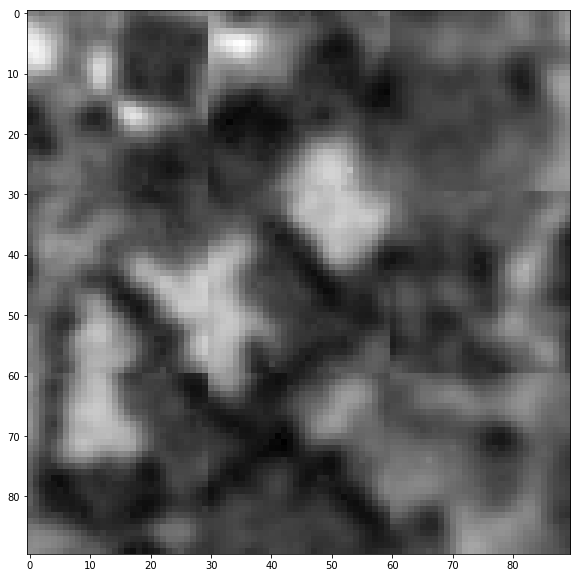

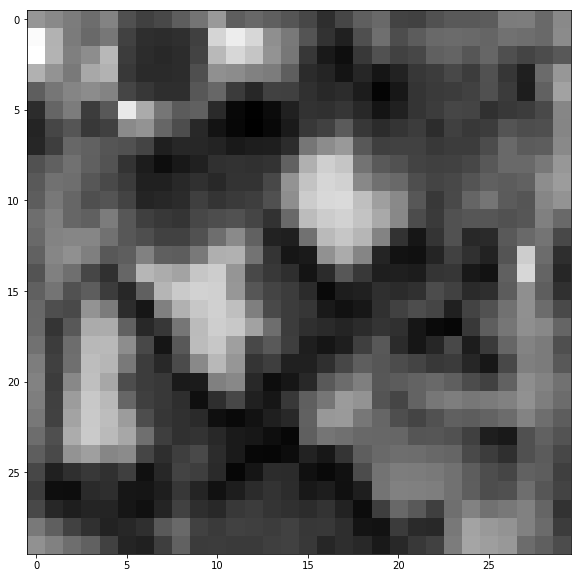

In [149]:
plt.figure(figsize=(10,10))
plt.imshow(picture[:90, :90], cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(rest_picture[:90, :90], cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(whole_pic(X[name])[:30, :30], cmap='gray')